In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, dendrogram



num_clusters = 6
train_count = 10000
plotted_point_count = 500

ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

ЗАПИСЫВАЕМ ДАННЫЕ В ТАБЛИЦЫ

In [12]:
import sqlite3
dfStr = pd.read_csv('checks_str.txt', sep='\t')   #Читаем чеки
dfTitles = pd.read_csv('checks_titles.txt', sep='\t')   #Читаем доп.инфу по каждому чеку
names = pd.read_csv('id.txt', sep='\t', names=['idtov','name'])  #Читаем ID каждого товара
data = pd.merge(dfStr, names, on='idtov') #Объединение чеков с именами товаров 

print(data.head())

   iddoc idtov  count  price  summa  \
0  227FR   92N    4.0   68.0  272.0   
1  22824   92N    2.0   68.0  136.0   
2  228CE   92N    2.0   68.0  136.0   
3  228CV   92N    2.0   68.0  136.0   
4  228D3   92N    6.0   68.0  408.0   

                                                name  
0  Батарейка Duracell Turbo LR 6 2BL             ...  
1  Батарейка Duracell Turbo LR 6 2BL             ...  
2  Батарейка Duracell Turbo LR 6 2BL             ...  
3  Батарейка Duracell Turbo LR 6 2BL             ...  
4  Батарейка Duracell Turbo LR 6 2BL             ...  


In [44]:
pyt = pd.DataFrame(list(Checks.objects.all()[:5].values()))
print(dfStr.head(5))
print("pyt:", pyt, sep="/n")


NameError: name 'Checks' is not defined

In [13]:
group_by_iddoc = data.groupby(['iddoc'])
ch = group_by_iddoc.sum() 
ch['count_uniq_good'] = group_by_iddoc.size()
ch  # ch - информация о каждом чеке (общая сумма, кол-во товаров и т.д)

C:\Users\kasae\AppData\Local\Temp\ipykernel_19384\4056925311.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ch = group_by_iddoc.sum()


,count,price,summa,count_uniq_good
iddoc,,,,
227FR,4.0,68.0,272.0,1
227FU,2.0,7.5,15.0,1
227FV,1.0,48.0,48.0,1
227FW,1.0,11.0,11.0,1
227FX,8.0,182.0,1456.0,1
...,...,...,...,...
2K3WT,2.0,39.0,78.0,1
2K3WU,14.0,554.0,1391.0,3
2K3WV,5.0,145.0,652.5,1


## K-means кластеризация

In [14]:
checks = ch.drop(columns=["price"])    #Удаляем поля
checks = checks[checks['count_uniq_good'] > 2]   #Используем только чеки с  >=  3 товарами
checks = checks[checks['summa'] > 0]   #Используем только чеки с суммой  >  0
checks.head()   #93920 results

,count,summa,count_uniq_good
iddoc,,,
227G1,10.0,38.60,3
227G9,3.0,233.00,3
227GA,44.0,2734.20,5
227GB,432.0,7506.00,20
227GG,3.0,1260.15,3


In [15]:


from sklearn import preprocessing

#cheks - чеки у которых больше 3-ех позиций и сумма больше 0
#нормализация данных
print(checks)
checks = pd.DataFrame(preprocessing.normalize(checks, axis=0), index = checks.index.values) #Приводим все в числа от 0 до 1
 
checks.columns=["kolvo","summa","count_uniq_good"]

trainDF = pd.DataFrame(checks[:train_count])  #Обрезаем нашу таблицу до 10000 чеков 
# trainDF - таблица, которую мы используем для тренировки ИИ

train = trainDF.values # Достаем только значения


       count    summa  count_uniq_good
iddoc                                 
227G1   10.0    38.60                3
227G9    3.0   233.00                3
227GA   44.0  2734.20                5
227GB  432.0  7506.00               20
227GG    3.0  1260.15                3
...      ...      ...              ...
2K3VS    7.0   383.00                3
2K3W7    5.0   342.00                3
2K3W8    4.0   421.00                3
2K3WU   14.0  1391.00                3
2K3WZ    4.0   596.00                3

[102653 rows x 3 columns]


In [16]:

#описываем модель
model = KMeans(n_clusters = num_clusters)

#Тренируем ИИ
model.fit(train)   

#Список того, к какой группе кластеров(групп, кол-во которых мы задали в num_clusters) принадлежит каждая строка из trainDF
#Мы можем сделать теперь это с любым объектом базы данных, и model.predict(object) скажет, к какому кластеру он относится
all_predictions = model.predict(train)

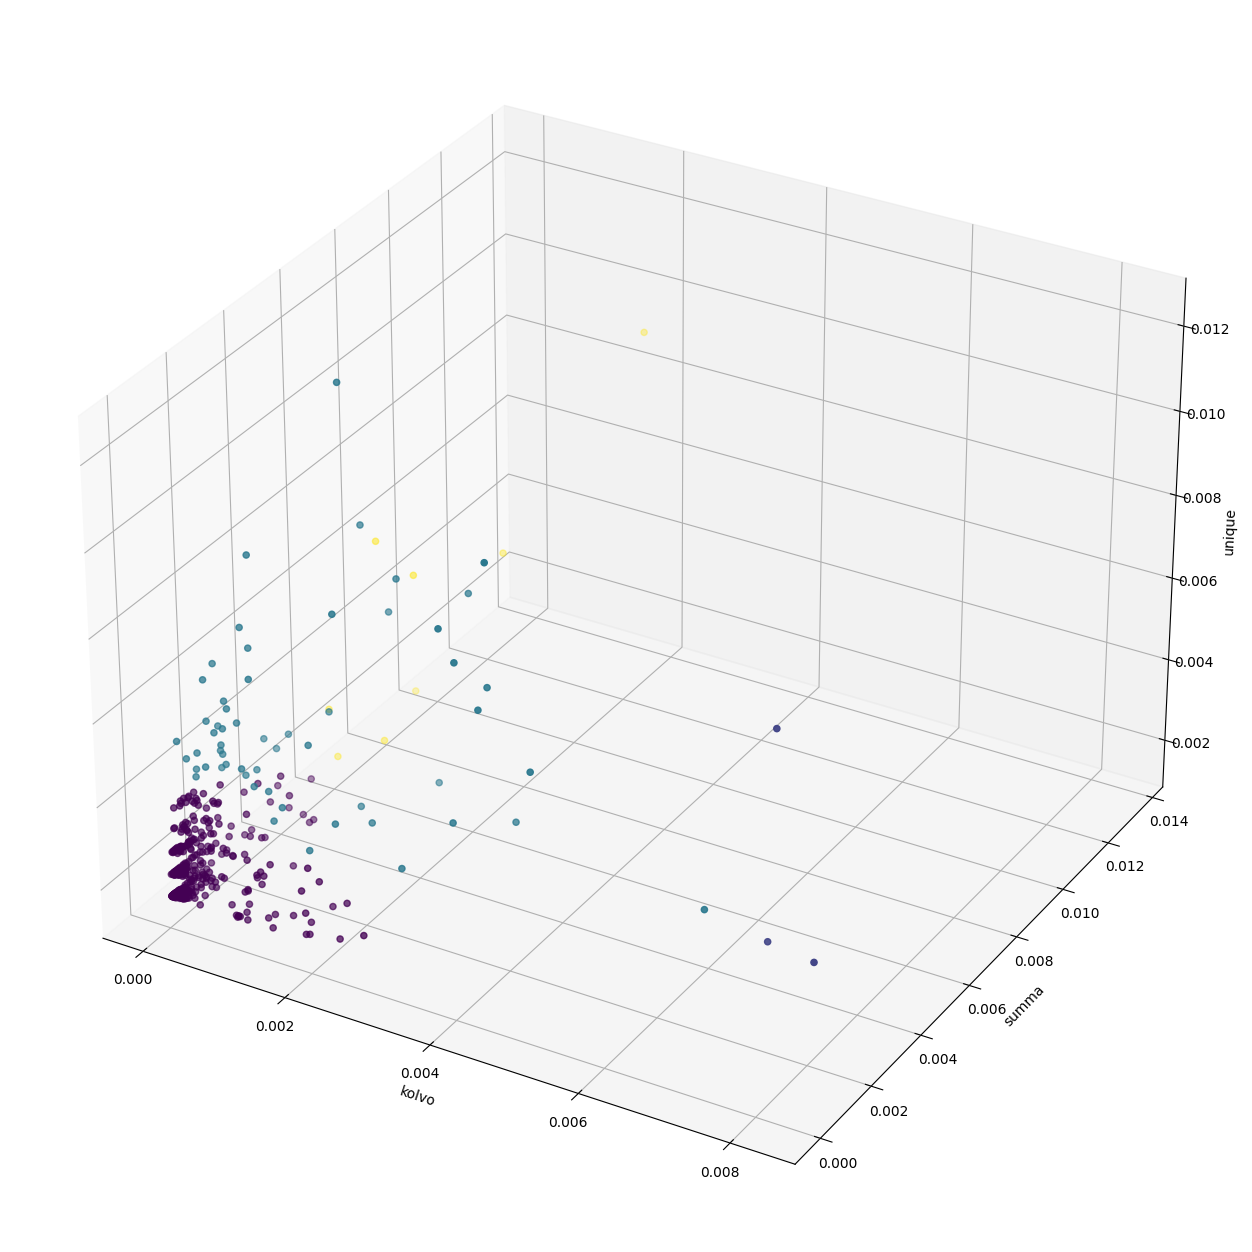

In [17]:
x_axis = train[:plotted_point_count, 0]   #Поля 'kolvo' во всех элемнетах спиаска train 
y_axis = train[:plotted_point_count, 1]
z_axis = train[:plotted_point_count, 2]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(xlabel="kolvo")
ax.set_ylabel(ylabel="summa")
ax.set_zlabel(zlabel="unique")
ax.scatter(x_axis, y_axis, z_axis, c=all_predictions[:plotted_point_count])

## Иерархическая кластеризация

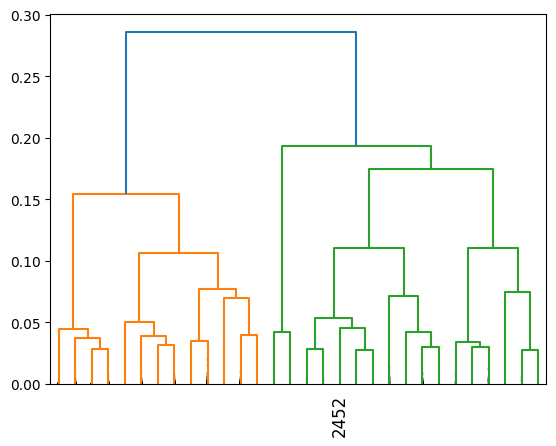

In [18]:
#сгенерировать матрицу связей

#проводим моделирование
mergings = linkage(train, method='ward') #Считает расс-ие между кластерами

#Выводим дендограму для анализа данных
dendrogram(mergings,
           truncate_mode='lastp',
           show_leaf_counts=False,
           leaf_rotation=90,
           leaf_font_size=12,
          show_contracted=True,)

plt.show()

In [19]:
mergings

array([[5.94900000e+03, 8.97800000e+03, 0.00000000e+00, 2.00000000e+00],
       [3.05400000e+03, 3.78900000e+03, 0.00000000e+00, 2.00000000e+00],
       [7.27000000e+03, 9.59600000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.99930000e+04, 1.99940000e+04, 1.74655888e-01, 2.47000000e+02],
       [1.99820000e+04, 1.99960000e+04, 1.92871857e-01, 2.53000000e+02],
       [1.99950000e+04, 1.99970000e+04, 2.85809797e-01, 1.00000000e+04]])

## Метод кластеризации на основе плотности DBSCAN

In [20]:
from sklearn.cluster import DBSCAN

# Определяем модель
dbscan = DBSCAN(eps=0.0005, min_samples=100) #Радиус и миним. кол-во точек в радиусе
 
# Обучаем
dbscan.fit(trainDF)


all_predictions = dbscan.labels_


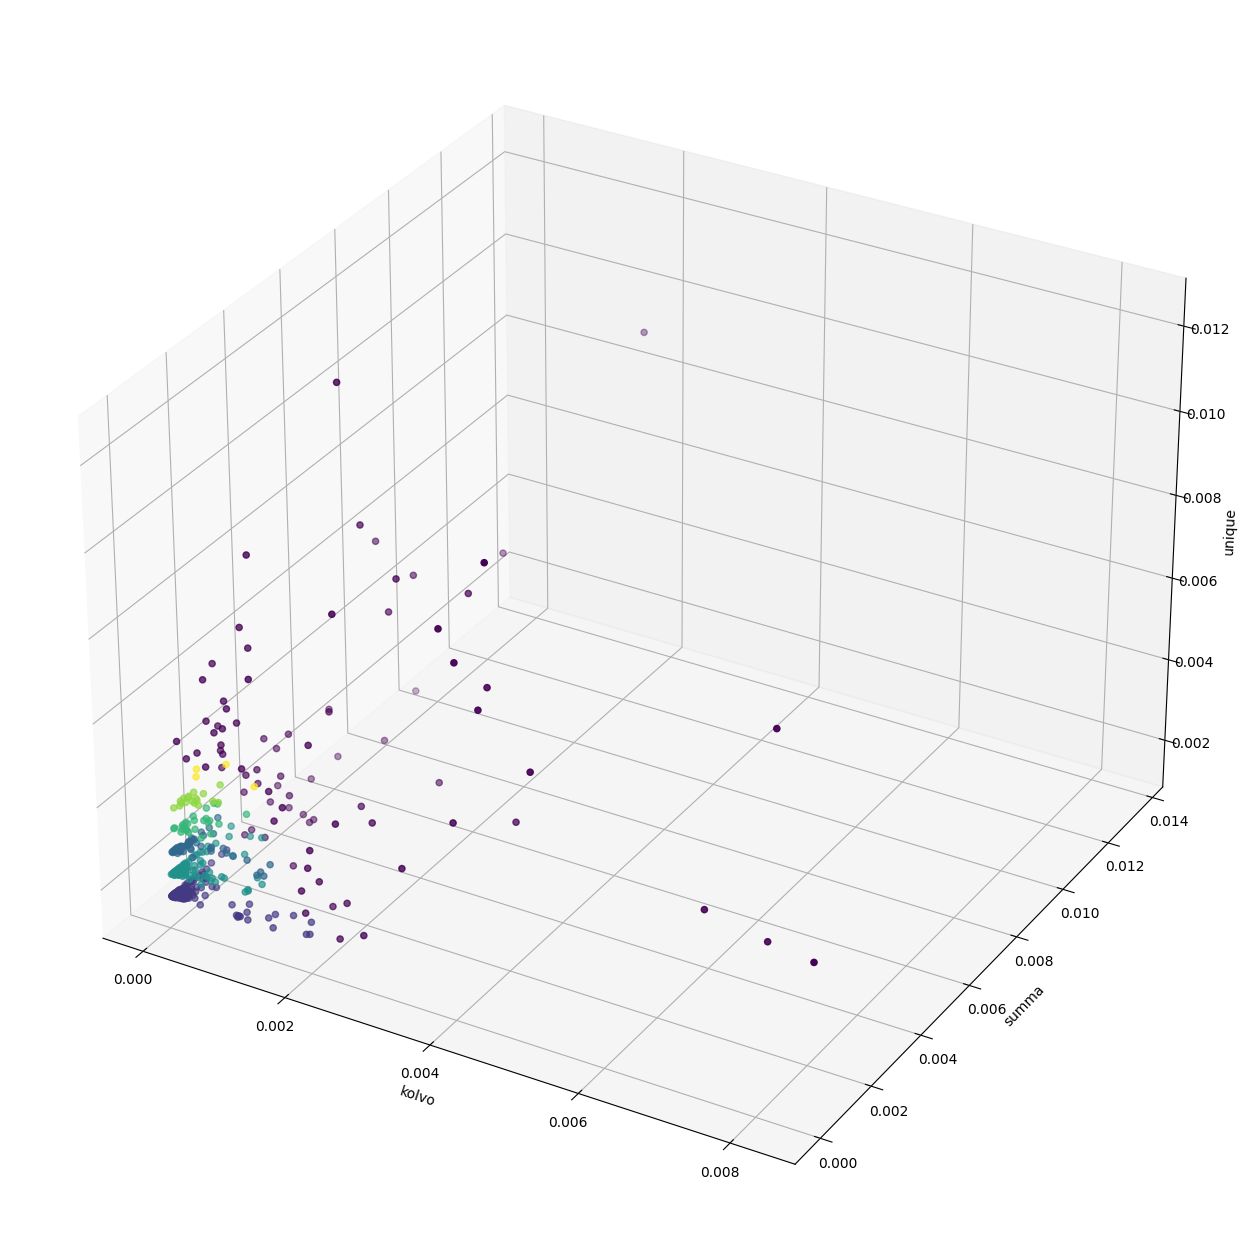

In [21]:
x_axis = train[:plotted_point_count, 0]
y_axis = train[:plotted_point_count, 1]
z_axis = train[:plotted_point_count, 2]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(xlabel="kolvo")
ax.set_ylabel(ylabel="summa")
ax.set_zlabel(zlabel="unique")
ax.scatter(x_axis, y_axis, z_axis, c=all_predictions[:plotted_point_count])


ТЕСТОВАЯ ПРОВЕРКА

In [22]:
dfrm = pd.Series({'predicted':all_predictions})  
trainDF['predicted'] = dfrm['predicted']    #Записываем для каждого элемента его кластер
trainDF

,kolvo,summa,count_uniq_good,predicted
227G1,0.000091,0.000008,0.001608,0
227G9,0.000027,0.000046,0.001608,0
227GA,0.000399,0.000535,0.002681,1
227GB,0.003914,0.001468,0.010723,-1
227GG,0.000027,0.000247,0.001608,0
...,...,...,...,...
23V18,0.000263,0.006772,0.004289,-1
23V1E,0.000136,0.000754,0.002145,2
23V1F,0.000734,0.002006,0.005897,-1
23V1J,0.000045,0.000317,0.002681,1


In [23]:
#Тест
import recommendation
testCheck = pd.DataFrame(checks[train_count+10:train_count+11]) #Берем 1 элемент для проверки
# print(testCheck)
pred = model.predict(testCheck.values) #Прогоняем через обученную модель на основе K-means и получаем номер кластера



In [24]:
a = []

for index, t in testCheck.iterrows():

    closest = model.predict(np.array([t.values])) #получаем номер кластера тестового чека
    similar_checks = pd.DataFrame(trainDF[trainDF['predicted']==closest[0]]) #Все чеки с таким же кластером
    check_content = pd.DataFrame(data[data["iddoc"]==index]) #Все товары тестового чека
    print("Check content : ",check_content)
    
    #получить все товары из чеков с таким же кластером
    train_tov = pd.DataFrame(data[data['iddoc'].isin(similar_checks.index.values)])

    
    for check_index, tovar in check_content.iterrows():
        #отбираем все товары (из чеков с таким же кластером) у которых есть товары, как в тестовом чеке
        a.append(train_tov[train_tov['idtov'] == tovar['idtov']])
        
        
    a = pd.concat(a) #Создаем таблицу
    
    #Группируем из отдельных товаров в один чек (чек  -  кол-во товаров)
    a = pd.DataFrame(a.groupby(['iddoc']).size().reset_index(name='count')) 
    a = a.sort_values(by=['count', 'iddoc'], ascending=False) # Сортируем
    # a - Таблица:  Чек  -  кол-во товаров в чеке 


    b = []
    for ind, k in a.iterrows():    #(76 эл.)
        t = pd.DataFrame(data[data["iddoc"]==a.loc[ind]['iddoc']])  #Как train_tov, но там мы берем только некоторые товары, а здесь все
        b.extend(t.values) 
    #b - как a, но берем не только те товары из чека, которые есть в тестовом чеке, а  все товары с этого чека

    b = pd.DataFrame(b, columns = data.columns)
    summ = b.groupby(['idtov']).sum(numeric_only=True)    #Общая суммированная информация о каждом товаре
    summ['count_good'] = b.groupby(['idtov']).size()  #Добавление поля кол-ва товаров 
    summ = summ.sort_values(by = ['count_good'], ascending=False)  #Сортируем по кол-ву товаров
summ = pd.merge(summ, names, on='idtov')
# summ - сгруппированная(по idtov) суммированная информация о товарарах, которые мы отобрали из чеков(data), в которых есть товары из тестового чека

Check content :          iddoc idtov  count  price  summa  \
553040  23V4C   O9U    2.0  178.0  356.0   
570939  23V4C   VWU    2.0    6.0   12.0   
656467  23V4C   YRT    2.0  149.0  298.0   
656468  23V4C   YRT    2.0  149.0  298.0   

                                                     name  
553040  Сетевой шнур для светод.ленты 220V 3528 ES    ...  
570939  Заглушка д/ленты 220V 5050 ES                 ...  
656467  Лента LED 220V 60SMD 4.4W бел  IP65 ES        ...  
656468  Лента LED 220V 60SMD 4.4W бел  IP65 ES        ...  


In [25]:
for index, tov in check_content.iterrows():
    summ = summ[summ.idtov != tov.idtov]   #удаляем тестовые товары из summ
summ = summ.sort_values(by = ['count_good'], ascending=False)
summ.head(15)

,idtov,count,price,summa,count_good,name
3,UZR,10.0,488.0,1143.14,4,Лента LED 220V LS704 60SMD 4.4W тепл IP68 ...
4,O9T,3.0,534.0,534.00,3,Сетевой шнур для светод.ленты 220V 5050 ES ...
5,14IW,24.0,296.0,3552.00,2,Лента LED 220V 14.4W 60SMD синий IP68 Ecola ...
6,10SK,2.0,268.0,536.00,1,Лента LED 220V 60LED 14.4W бел IP65 ES ...
7,12TN,1.0,215.0,215.00,1,Лампа LED Camelion 17W E27 4500K A65 ...
8,144X,2.0,114.0,228.00,1,Лента LED 220V 4.8W 60SMD синий IP68 Ecola ...
9,14TL,10.0,299.0,2990.00,1,Лента LED 220V 24W 240SMD белый IP68 3014 SWG ...
10,1549,14.0,114.0,1596.00,1,Лента LED 220V 4.8W 60SMD 4200К IP68 Ecola ...
11,R1F,1.0,39.0,35.10,1,Переходник для ленты на 220V 5050 ES ...
12,VWV,3.0,6.0,18.00,1,Заглушка д/ленты 220V 3528 ES ...


In [26]:
a = [4,2,3,4]

print(a[None: None])

[4, 2, 3, 4]
